# Import important libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Define important configurations


In [2]:
train_path = "/kaggle/input/archive/train"
test_path = "/kaggle/input/archive/test"

IMG_HEIGHT = 48
IMG_WIDTH = 48

BATCH_SIZE = 64 # for model.fit()
EPOCHS = 40

LR = 0.0002
NUM_CLASSES = 7
PATIENCE = 4 # For Early stopping

CLASS_LABELS  = ['Surprise', 'Fear', 'Anger', 'Neutral', 'Sadness', 'Disgust', 'Happy']

# Data Input and Data Augumentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range = 10
                                  )

train_generator = train_datagen.flow_from_directory(
                        directory = train_path,
                        target_size = (IMG_HEIGHT ,IMG_WIDTH),
                        batch_size = BATCH_SIZE,
                        shuffle  = True , 
                        class_mode = "categorical",
                        subset = "training",
                        seed = 12
                       )

validation_generator = train_datagen.flow_from_directory(
                        directory = train_path,
                        target_size = (IMG_HEIGHT ,IMG_WIDTH),
                        batch_size = BATCH_SIZE,
                        shuffle  = True , 
                        class_mode = "categorical",
                        subset = "validation",
                        seed = 12
                    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


# Display some preprocessing statistics

**Classes counting**

In [4]:
ctg = os.listdir(train_path)
counts = []
for e in ctg:
    counts.append(len(os.listdir(train_path + f'/{e}')))
    
counts

[3171, 4097, 3995, 4965, 4830, 436, 7215]

In [5]:
df_hist = pd.DataFrame()
df_hist['category'] = CLASS_LABELS 
df_hist['count'] = counts
df_hist

,category,count
0,Surprise,3171
1,Fear,4097
2,Anger,3995
3,Neutral,4965
4,Sadness,4830
5,Disgust,436
6,Happy,7215


**Classes counting visualization**

In [6]:
px.bar(df_hist, x='category', y='count')

# Get traninng features (images) and corresponding labels

In [7]:
imgs, labels = next(validation_generator)  
validation_generator.reset()
len(imgs)

64

# Let's take a brief look at images data

(48, 48, 3)


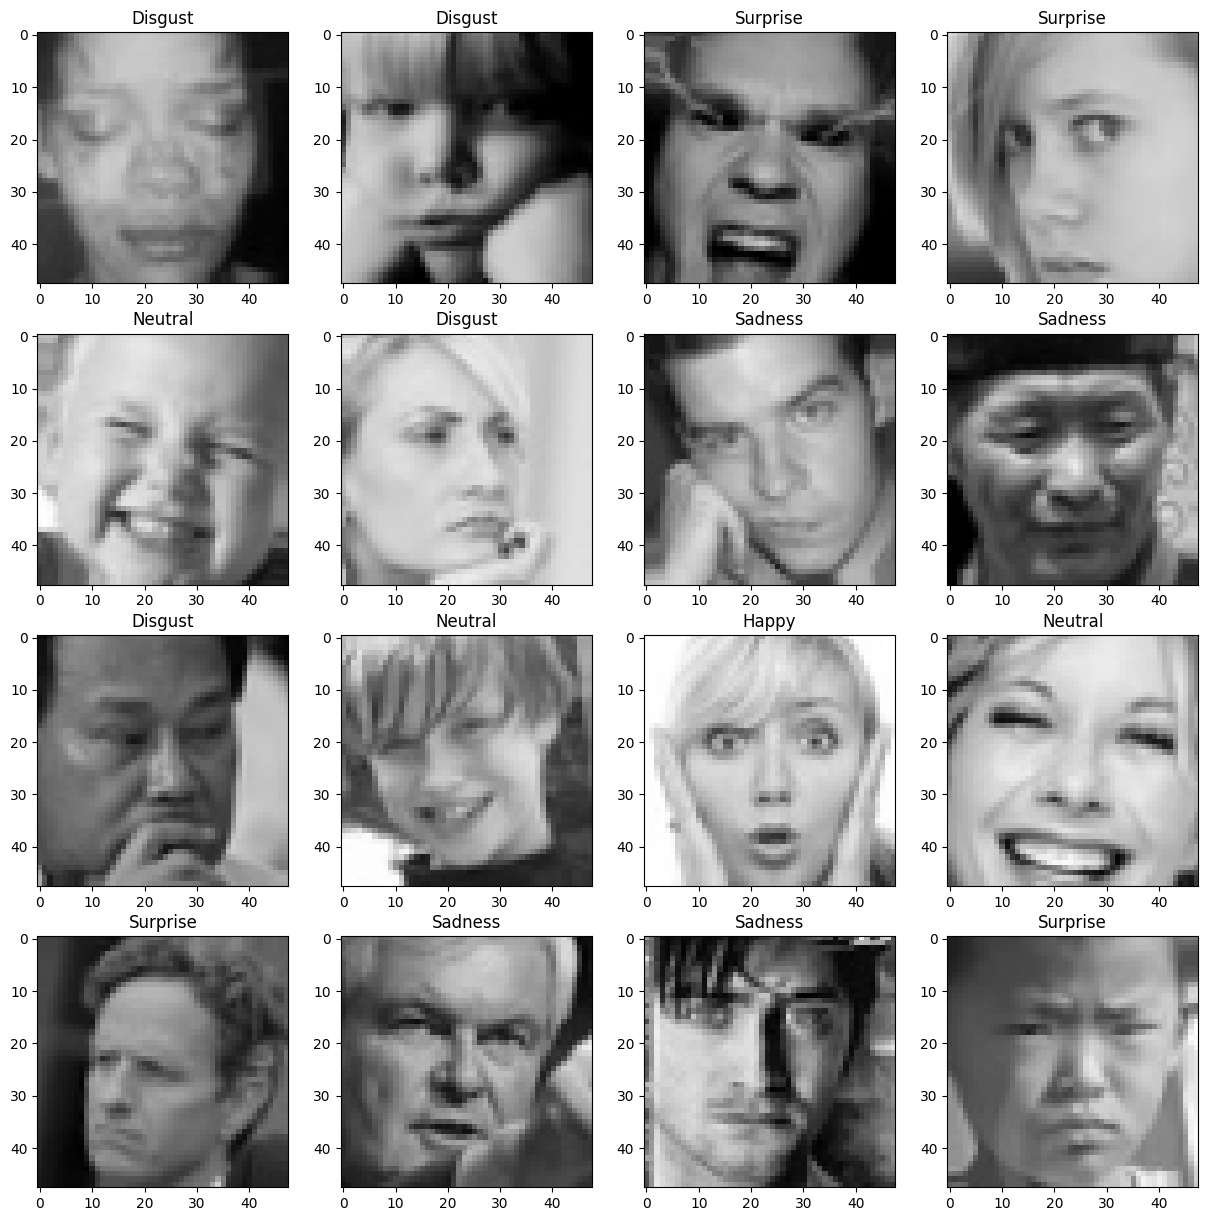

In [8]:
img = imgs[0]
print(img.shape)

plt.figure(figsize=(15,15))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i])
    plt.title(CLASS_LABELS[np.argmax(labels[i])])
plt.show()

# Building model

In [9]:
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten,Dense,Dropout,Activation,BatchNormalization,GlobalAveragePooling2D
from keras.models import Model,Sequential
from keras import regularizers
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [10]:
Simple_CNN_model = Sequential()

Simple_CNN_model.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv1', 
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3) ))
Simple_CNN_model.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv2'))
Simple_CNN_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block1_maxpool'))

Simple_CNN_model.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv1'))
Simple_CNN_model.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv2'))
Simple_CNN_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block2_maxpool'))
Simple_CNN_model.add(Dropout(0.25))

Simple_CNN_model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv1'))
Simple_CNN_model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv2'))
Simple_CNN_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block3_maxpool'))

Simple_CNN_model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv1'))
Simple_CNN_model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv2'))
Simple_CNN_model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv3'))
Simple_CNN_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block4_maxpool'))
Simple_CNN_model.add(Dropout(0.25))


Simple_CNN_model.add(Flatten())
Simple_CNN_model.add(Dense(4096, activation='relu'))
Simple_CNN_model.add(Dense(4096, activation='relu'))
Simple_CNN_model.add(Dense(NUM_CLASSES, activation='softmax'))

Simple_CNN_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_maxpool (MaxPooling2D)   │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_maxpool (MaxPooling2D)   │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_maxpool (MaxPooling2D)   │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_maxpool (MaxPooling2D)   │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    18,878,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,733,639 (163.02 MB)

 Trainable params: 42,733,639 (163.02 MB)

 Non-trainable params: 0 (0.00 B)

# Enhance model techniques

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


Simple_CNN_model.compile(
    optimizer = Adam(learning_rate = LR), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

checkpoint = ModelCheckpoint("checkpoint_weights.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          patience= PATIENCE,
                          verbose=1,
                          restore_best_weights=True
                          )

CALLBACKS = [early_stopping, checkpoint]

# Model training

In [12]:
history = Simple_CNN_model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks = CALLBACKS 
                   )

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1733972557.645061     109 service.cc:145] XLA service 0x7fc13c0158c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733972557.645121     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733972557.645125     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/359 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.2383 - loss: 4.4172   

I0000 00:00:1733972567.956102     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 126s 310ms/step - accuracy: 0.2535 - loss: 2.0209 - val_accuracy: 0.3581 - val_loss: 1.6267
Epoch 2/40


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning:

Can save best model only with val_acc available, skipping.



359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 131ms/step - accuracy: 0.3798 - loss: 1.5862 - val_accuracy: 0.4285 - val_loss: 1.4580
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 133ms/step - accuracy: 0.4466 - loss: 1.4304 - val_accuracy: 0.4767 - val_loss: 1.3568
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 133ms/step - accuracy: 0.4920 - loss: 1.3270 - val_accuracy: 0.5144 - val_loss: 1.2689
Epoch 5/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.5239 - loss: 1.2445 - val_accuracy: 0.5060 - val_loss: 1.2472
Epoch 6/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 135ms/step - accuracy: 0.5403 - loss: 1.1975 - val_accuracy: 0.5513 - val_loss: 1.1826
Epoch 7/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 132ms/step - accuracy: 0.5601 - loss: 1.1555 - val_accuracy: 0.5574 - val_loss: 1.1591
Epoch 8/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 134ms/step - accuracy: 0.5825 - loss: 1.1020 - val_accuracy: 0.5600 - val_loss: 1.1507
Epoch 9/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.5977 - loss: 1.0664 - val

# Saving model 

In [13]:
Simple_CNN_model.save('./model/simple_CNN_model.h5')


# Evaluation


**Loss and Accuracy of Training Process**


In [14]:
def plot_analysis(m):
  plt.figure(figsize=(10,5))

  plt.subplot(1,2,1)

  plt.plot(m.history['loss'],color="#E74C3C")
  plt.plot(m.history['val_loss'],color='#641E16')

  plt.title('Validation loss vs Train loss',fontsize=8)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'validation'], loc='upper right')

  plt.subplot(1,2,2)

  plt.plot(m.history['accuracy'],color="#E74C3C")
  plt.plot(m.history['val_accuracy'],color='#641E16')

  plt.title('Validation accuracy vs Train accuracy',fontsize=8)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'validation'], loc='lower right')

  plt.show()

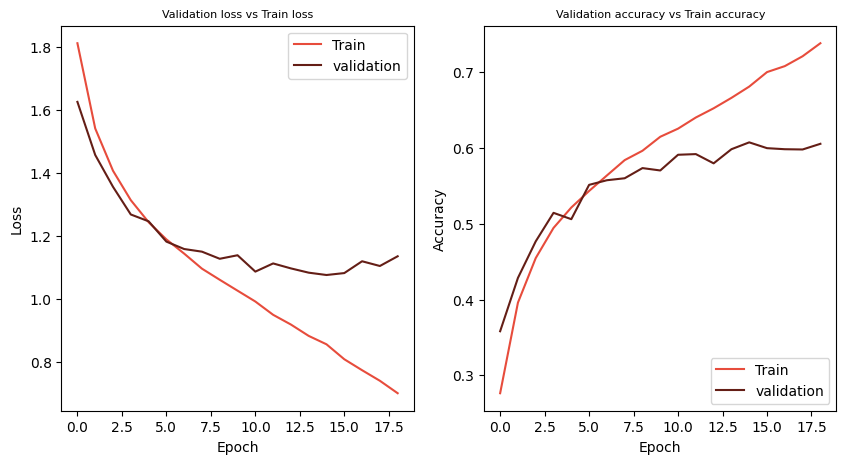

In [15]:
plot_analysis(history)

# Evaluate on test set


**Get test data**


In [16]:
test_datagen = ImageDataGenerator(
                                rescale = 1./255,
                                    )

test_generator = test_datagen.flow_from_directory(
                        directory = test_path,
                        target_size = (IMG_HEIGHT ,IMG_WIDTH),
                        batch_size = BATCH_SIZE,
                        class_mode = "categorical",
                        shuffle = False,
                      )

Found 7178 images belonging to 7 classes.


**Evalute on test set**

In [17]:
e = Simple_CNN_model.evaluate(x=test_generator, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - accuracy: 0.5732 - loss: 1.1626


**Classification Report**

In [18]:
test_generator.reset()
p = Simple_CNN_model.predict(test_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step


In [19]:
test_generator.reset()
labels_test = [CLASS_LABELS[item] for item in test_generator.labels]
labels_pred = [CLASS_LABELS[np.argmax(item)] for item in p]

from sklearn.metrics import *
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

       Anger       0.46      0.36      0.40      1024
     Disgust       0.51      0.41      0.45      1247
        Fear       0.46      0.53      0.49       111
       Happy       0.68      0.81      0.74       831
     Neutral       0.85      0.81      0.83      1774
     Sadness       0.52      0.66      0.58      1233
    Surprise       0.53      0.55      0.54       958

    accuracy                           0.61      7178
   macro avg       0.57      0.59      0.58      7178
weighted avg       0.61      0.61      0.61      7178



**Confusion matrix**


In [20]:
cfm = confusion_matrix(labels_test, labels_pred)

import plotly.figure_factory as ff

# Set up figure 
fig = ff.create_annotated_heatmap(np.flipud(cfm)
, x = CLASS_LABELS, y = list(np.flip(CLASS_LABELS)), colorscale='Purples')

# Add titles
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  xaxis = dict(title='Predicted label'),
                  yaxis = dict(title='True label'))

# Adjust margins (top, left), width and height
fig.update_layout(margin=dict(t=100, l=100), width = 750, height = 750)

# Add colorbar
fig['data'][0]['showscale'] = True

fig.show()